In [10]:
# Set up
%pylab inline

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats
import seaborn.apionly as sns

"""
# Examples - top causal 
causal = pd.read_csv("/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/Merged_Best_causality.Table", sep="\t")
causal = causal[causal["top.variant"].apply(lambda x: "SNP" not in x)]
causal = causal.sort_values("best.score", ascending=False)

num = 100
GENES = list(causal["gene"])[0:num]
CHROMS = list(causal["chrom"].apply(lambda x: x[3:]))[0:num]
STARTS = list(causal["best.str.start"])[0:num]
TISSUES = list(causal["best.tissue"])[0:num]
"""

# Examples - near TSS
num = 100
FEATUREDIR = "/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/"
data = pd.read_csv(os.path.join(FEATUREDIR, "GTEx_merged_causality_tsstes.tab"), sep="\t")
data = data[data["dist.to.tss"].apply(abs)<=1000]
data = data.sort_values("dist.to.tss")
data = data.head(n=num)
GENES = list(data["gene"])
TISSUES = list(data["best.tissue"])
STARTS = list(data["best.str.start"])
CHROMS = list(data["chrom"])
QVALS = list(data["best.q"])

COLORS = {
    "Artery-Aorta":"salmon",
    "Artery-Tibial": "red",
    "Adipose-Subcutaneous": "darkorange",    
    "Adipose-Visceral(Omentum)":"orange",
    "Brain-Caudate(basalganglia)":"lemonchiffon"   , 
    "Brain-Cerebellum":"yellow",
    "Cells-Transformedfibroblasts": "skyblue",
    "Esophagus-Mucosa": "sienna",
    "Esophagus-Muscularis":"burlywood",
    "Heart-LeftVentricle":"darkviolet",
    "Lung": "greenyellow",
    "Muscle-Skeletal": "mediumslateblue",
    "Nerve-Tibial":"gold",
    "Skin-NotSunExposed(Suprapubic)":"blue",
    "Skin-SunExposed(Lowerleg)":"cornflowerblue",
    "Thyroid":"green",
    "WholeBlood": "m",
    "permuted": "gray"
}

Populating the interactive namespace from numpy and matplotlib


In [11]:
def ExtractData(gene, chrom, start, tissue):
    if "(" in tissue: tissue = tissue.split("(")[0]
    vcf = "/storage/szfeupe/Runs/650GTEx_estr/Merged_STRs_all_samples.vcf.gz"
    # Pull out STR genotypes
    cmd = """bcftools query -r %s:%s-%s -f"[%%SAMPLE\\t%%GB\\n]" %s | \
    grep -v "\." | sed 's/|/\\t/' | awk '{print $1 "\\t" $2+$3}' > str_genotypes.tab"""%(chrom, start, start, vcf)
    os.system(cmd)
    # Pull out STR genotypes - alleles
    cmd = """bcftools query -r %s:%s-%s -f"[%%SAMPLE\\t%%GB\\n]" %s | \
    grep -v "\." | sed 's/|/\\t/' | awk '{print $1 "\\t" $2","$3}' > str_genotypes_alleles.tab"""%(chrom, start, start, vcf)
    os.system(cmd)
    # Pull out gene expression
    expr="/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/%s/Corr_Expr.csv"%tissue
    colnum = open(expr,"r").readline().split(",").index('"' + gene + '"')+2
    cmd = """cat %s | cut -d',' -f 1,%s | grep -v ENSG > expr.tab"""%(expr, colnum)
    os.system(cmd)

def PlotESTR(gene, tissue, chrom, start, COLORS):
    strgt = pd.read_csv("str_genotypes.tab", sep="\t", names=["sample","str"])
    strgt["sample"] = strgt["sample"].apply(lambda x: "-".join(x.split("-")[0:2]))
    
    rmgts = []
    for gt in sorted(list(set(strgt["str"]))):
        if strgt[strgt["str"]==gt].shape[0] <3: rmgts.append(gt)
    strgt = strgt[strgt["str"].apply(lambda x: x not in rmgts)]
        
    fig = plt.figure()
    ax = fig.add_subplot(111)
    expr = pd.read_csv("expr.tab", names=["sample","expr"])
    data = pd.merge(strgt, expr)
    sns.swarmplot(x="str", y="expr", ax=ax, data=data, color=COLORS[tissue])
    ax.set_xlabel("bp (rel. to hg19)", size=15)
    ax.set_ylabel("Expression - %s"%tissue, size=15)
    ax.set_xticklabels([int(item) for item in sorted(list(set(data["str"])))], size=12)
    ax.set_yticklabels(["%.2f"%(item) for item in ax.get_yticks()], size=12)
    ax.set_title("")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title("chr%s:%s - %s"%(chrom, start, gene))
    plt.suptitle("");
    plt.show()
    fig.savefig("%s_estr.pdf"%gene)

def PlotHeatmap():
    strgt = pd.read_csv("str_genotypes_alleles.tab", sep="\t", names=["sample","GB"])
    strgt["sample"] = strgt["sample"].apply(lambda x: "-".join(x.split("-")[0:2]))
    strgt["str"] = strgt["GB"].apply(lambda x: sum([int(item) for item in x.split(",")]))
    rmgts = []
    for gt in sorted(list(set(strgt["str"]))):
        if strgt[strgt["str"]==gt].shape[0] <3: rmgts.append(gt)
    strgt = strgt[strgt["str"].apply(lambda x: x not in rmgts)]

    expr = pd.read_csv("expr.tab", names=["sample","expr"])
    correxpr = pd.merge(strgt, expr)
    # Heatmap
    alleles = set()
    for i in range(correxpr.shape[0]):
        a1, a2 = correxpr["GB"].values[i].split(",")
        alleles.add(int(a1))
        alleles.add(int(a2))
    alleles = sorted(list(alleles))

    exprmatrix = np.zeros((len(alleles), len(alleles)))
    counts = np.zeros((len(alleles), len(alleles)))
    for i in range(correxpr.shape[0]):
        a1, a2 = correxpr["GB"].values[i].split(",")
        a1 = int(a1)
        a2 = int(a2)
        if a1<a2:
            a1ind = alleles.index(a1)
            a2ind = alleles.index(a2)
        else: 
            a1ind = alleles.index(a2)
            a2ind = alleles.index(a1)
        exprmatrix[a1ind,a2ind] += correxpr["expr"].values[i]
        exprmatrix[a2ind,a1ind] += correxpr["expr"].values[i]
        counts[a1ind,a2ind] += 1
        counts[a2ind,a1ind] += 1
    exprmatrix = exprmatrix/(counts+1)

    sns.heatmap(exprmatrix, xticklabels=alleles, yticklabels=alleles)
    
    # Plot each row of the matrix
    #fig = plt.figure()
    #ax = fig.add_subplot(111)
    #for i in range(exprmatrix.shape[0]):
    #    vals = exprmatrix[i,:]
    #    if sum(counts[i,:]) < 25: continue
    #    nvals = []
    #    for item in vals:
    #        if item == 0: nvals.append(None)
    #        else: nvals.append(item)
    #    ax.plot(alleles, nvals, label=alleles[i])
    #ax.legend()

ENSG00000100804.14,chr14,23505427,Skin-NotSunExposed(Suprapubic) 0.492171410511669


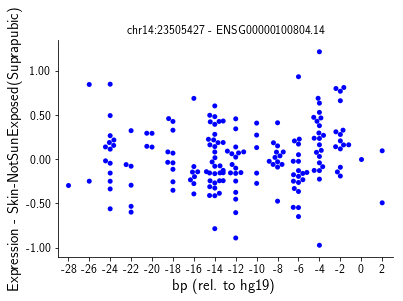

ENSG00000114529.8,chr3,111804196,Artery-Aorta 0.45367213319076394


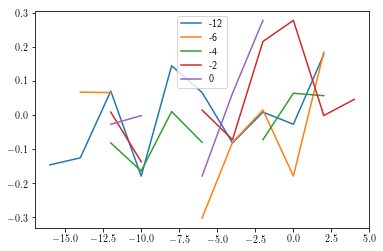

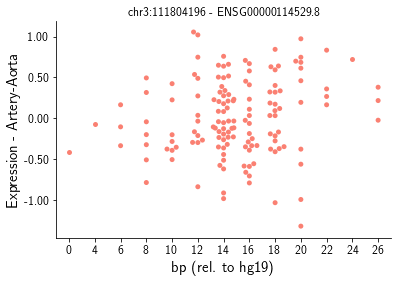

ENSG00000160808.5,chr3,46924629,Heart-LeftVentricle 0.32183439100537103


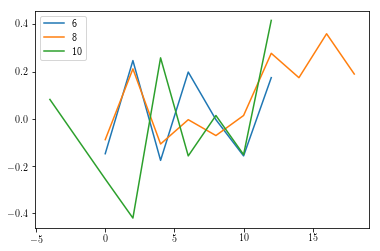

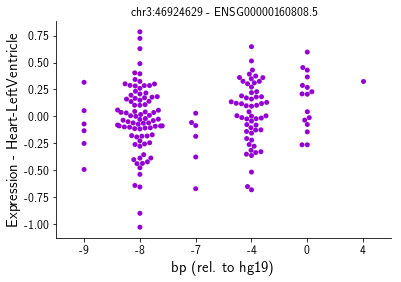

ENSG00000137090.7,chr9,840725,Thyroid 0.323766313791016


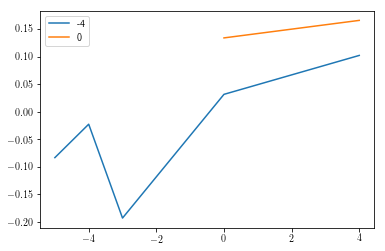

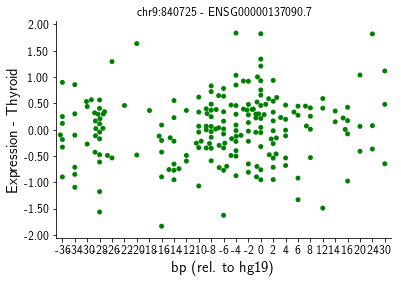

ENSG00000054611.9,chr22,47157584,Muscle-Skeletal 0.200014577108978


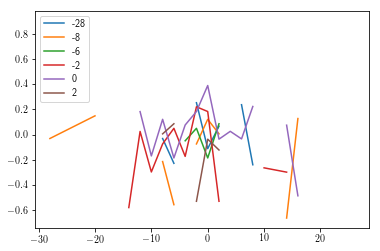

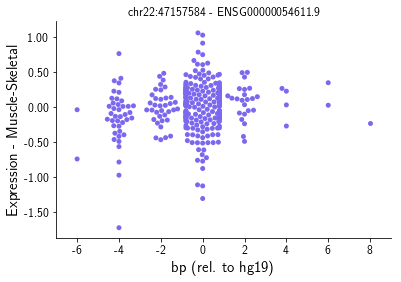

ENSG00000110107.4,chr11,60674993,Adipose-Subcutaneous 0.18028510072700304


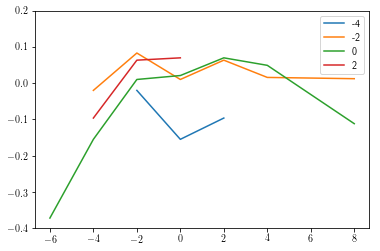

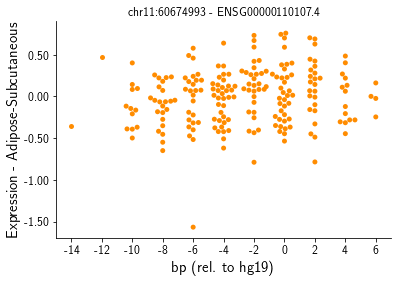

ENSG00000160200.13,chr21,44497976,Artery-Tibial 0.0226088147923564


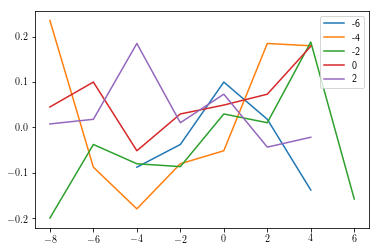

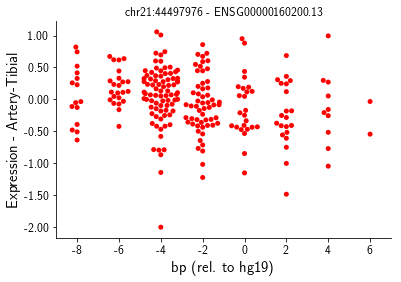

ENSG00000179163.11,chr1,24195706,Cells-Transformedfibroblasts 0.0034671569970244


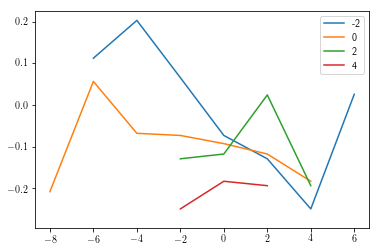

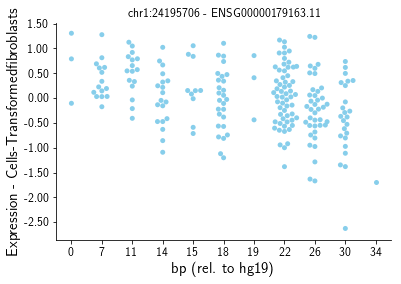

ENSG00000178175.7,chr5,71804473,Muscle-Skeletal 0.365183767510478


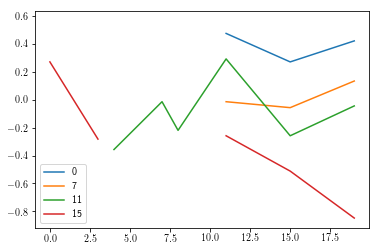

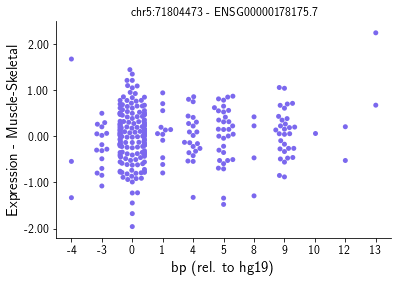

ENSG00000184209.14,chr12,123941284,Brain-Cerebellum 0.0976676192816666


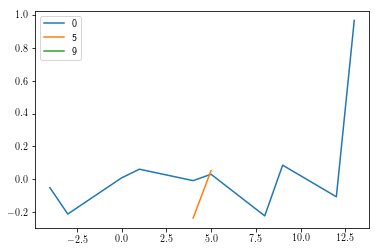

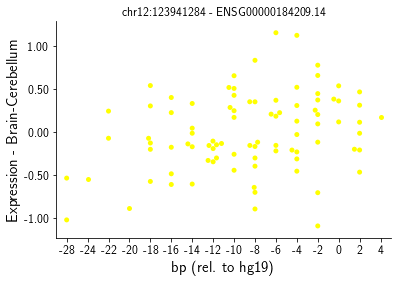

ENSG00000180316.7,chr6,36210083,Esophagus-Muscularis 0.488284234212682


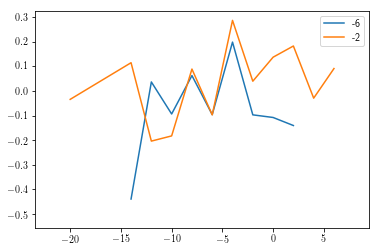

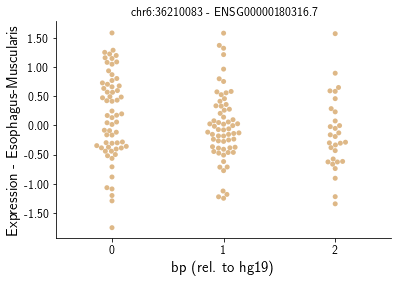

ENSG00000119900.7,chr6,71997611,Esophagus-Muscularis 0.00465846867123046


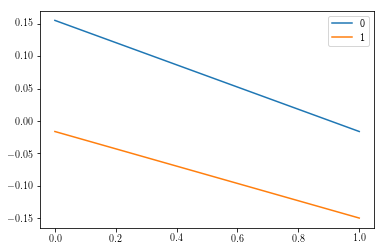

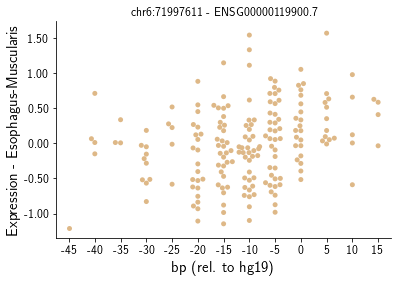

ENSG00000145321.8,chr4,72670633,Cells-Transformedfibroblasts 0.36015642579525003


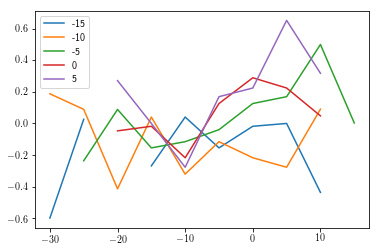

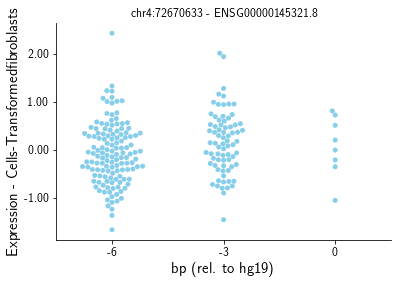

ENSG00000124102.4,chr20,43802657,Lung 0.0848338901269668


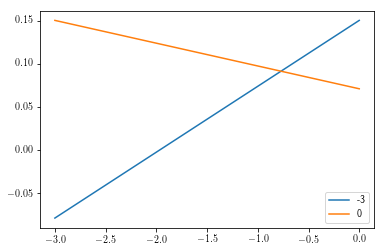

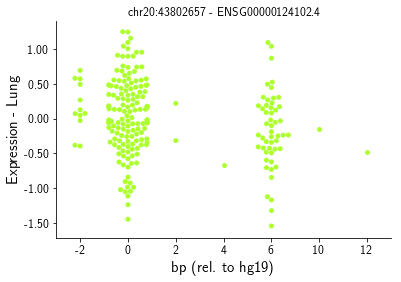

ENSG00000141959.12,chr21,45719081,Brain-Caudate(basalganglia) 0.37428798420190995


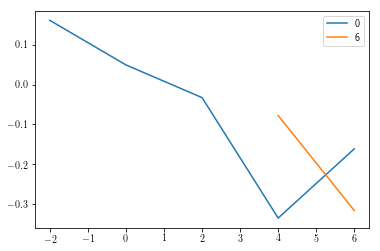

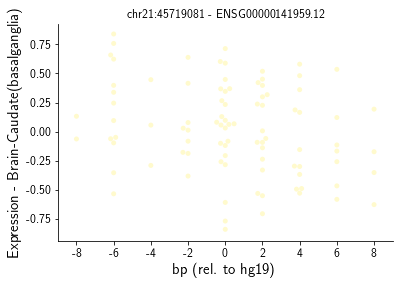

ENSG00000135436.4,chr12,50000270,WholeBlood 0.627249263676941


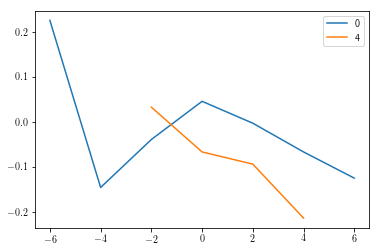

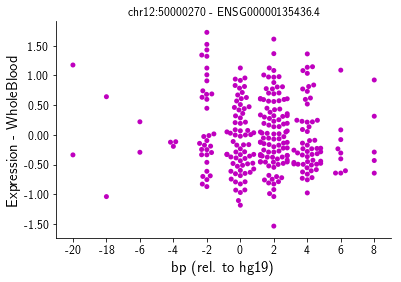

ENSG00000161970.8,chr17,8287369,Skin-SunExposed(Lowerleg) 0.5998896226441619


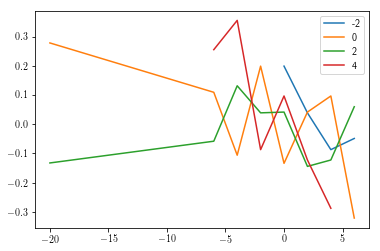

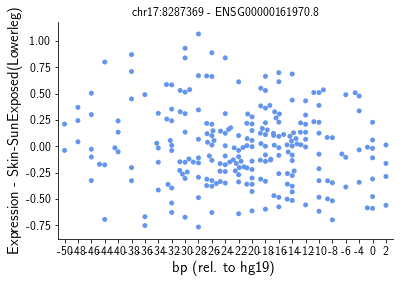

ENSG00000141376.16,chr17,58753999,Nerve-Tibial 0.152434669724789


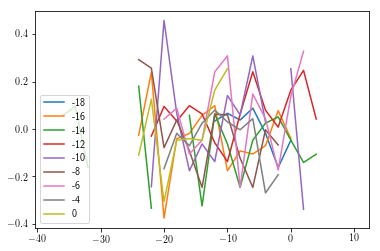

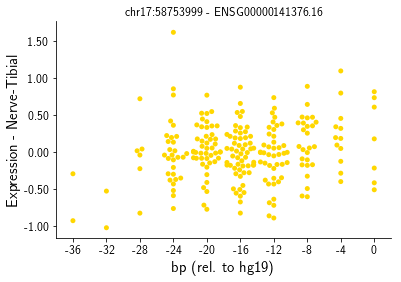

ENSG00000005175.5,chr12,48100652,Skin-SunExposed(Lowerleg) 0.0462128401949937


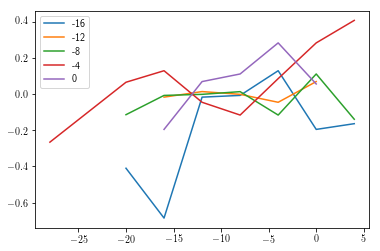

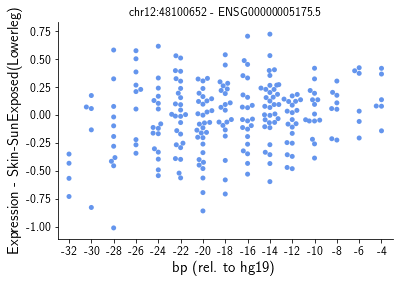

ENSG00000124228.10,chr20,47835079,Brain-Caudate(basalganglia) 0.0919593504830626


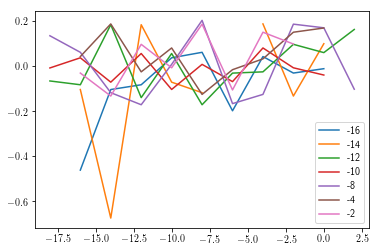

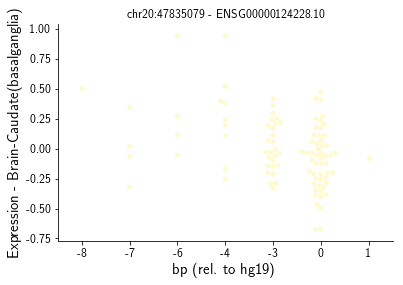

ENSG00000130475.10,chr19,17857762,Cells-Transformedfibroblasts 0.0599234619015026


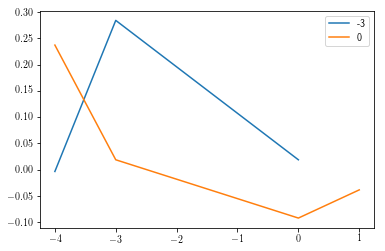

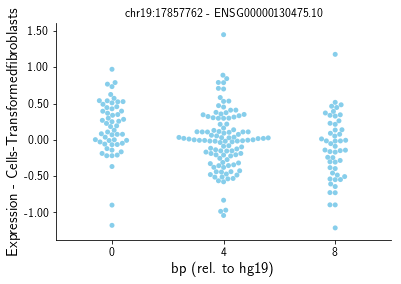

ENSG00000234465.6,chr19,44080629,Brain-Caudate(basalganglia) 0.0216199740410529


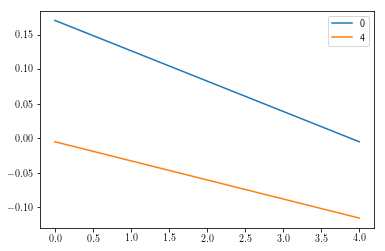

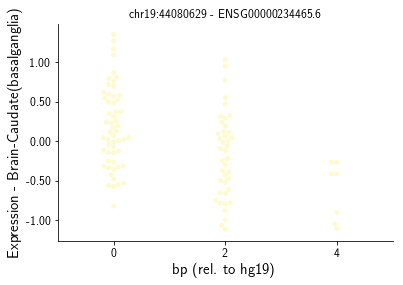

ENSG00000176624.9,chr18,48745388,Nerve-Tibial 0.0448678031664041


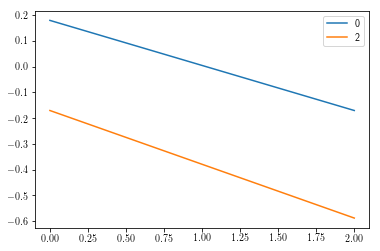

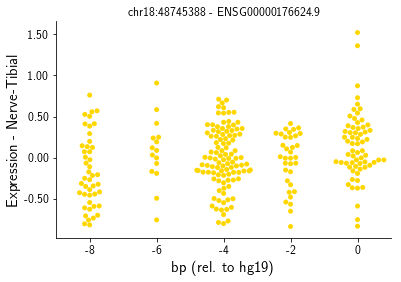

ENSG00000165379.9,chr14,42076071,Thyroid 0.0052085116968762


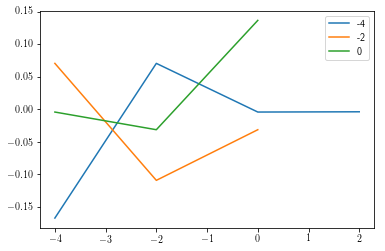

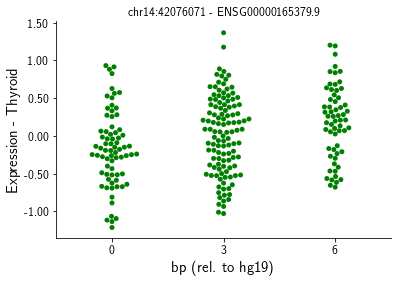

ENSG00000101425.8,chr20,36887852,Cells-Transformedfibroblasts 0.24075402166391704


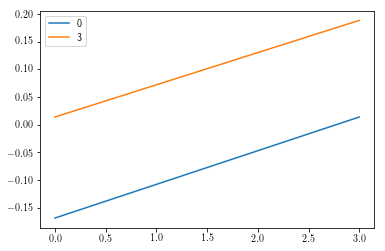

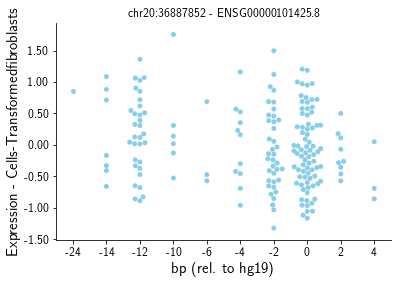

ENSG00000141391.9,chr18,12407248,WholeBlood 0.9708551056900642


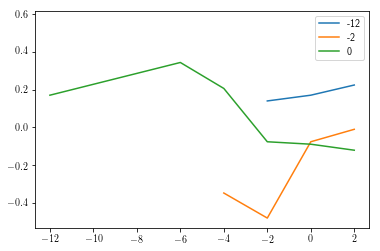

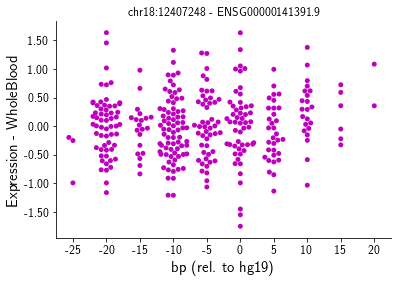

ENSG00000196352.9,chr1,207494222,Adipose-Visceral(Omentum) 0.0059577820333256


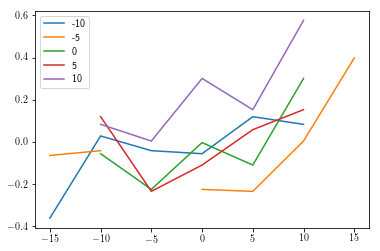

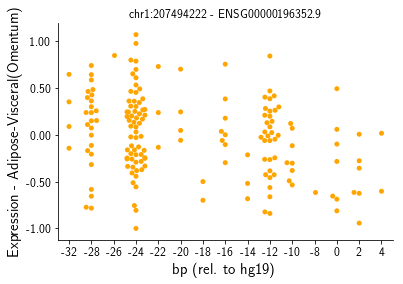

ENSG00000157211.10,chr1,54620052,Adipose-Visceral(Omentum) 0.28573762968215005


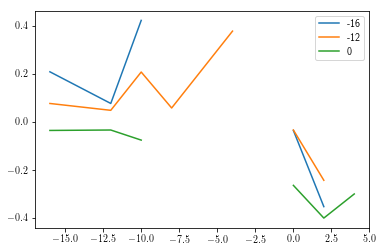

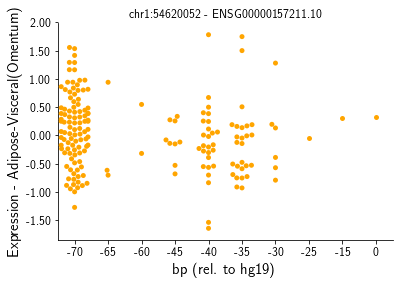

ENSG00000104714.9,chr8,688675,Muscle-Skeletal 0.20616398573506686


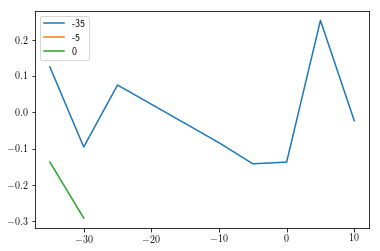

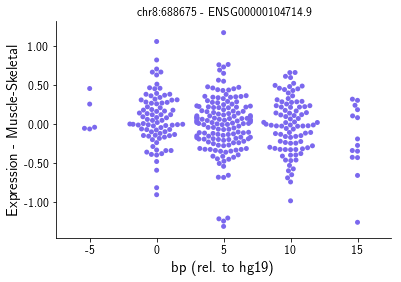

ENSG00000162929.9,chr2,61292453,Adipose-Visceral(Omentum) 0.28657695867166305


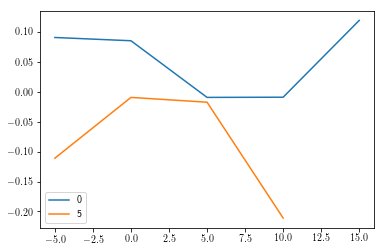

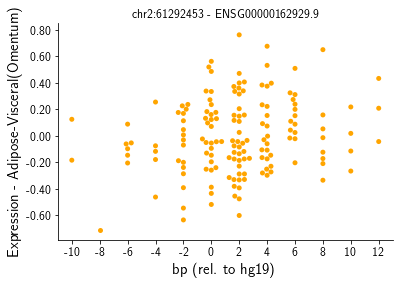

ENSG00000120688.7,chr13,41635051,Esophagus-Muscularis 0.4506195066934601


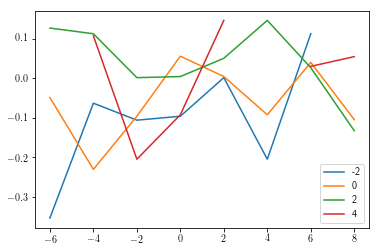

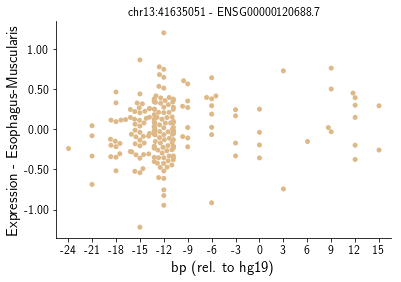

ENSG00000160113.5,chr19,17357242,Lung 0.24655151311171


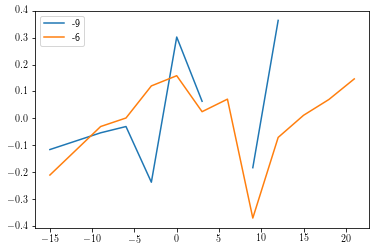

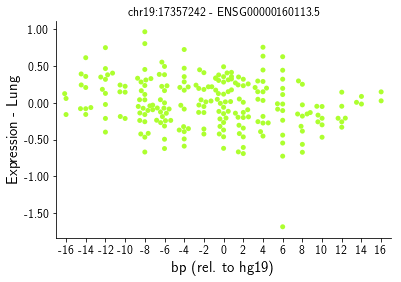

ENSG00000081041.8,chr4,74965502,Nerve-Tibial 0.0442777294020479


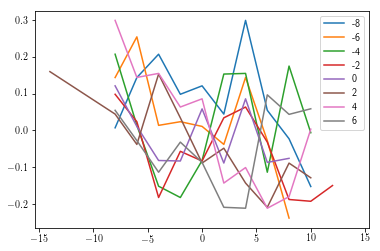

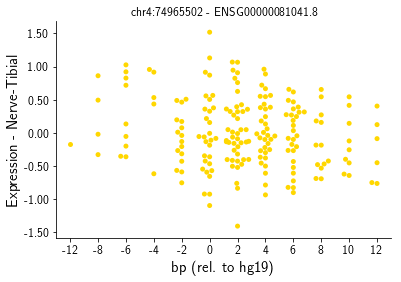

ENSG00000096746.13,chr10,70090467,Esophagus-Muscularis 0.46270425025308


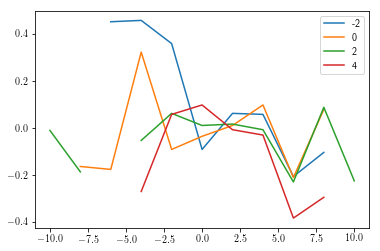

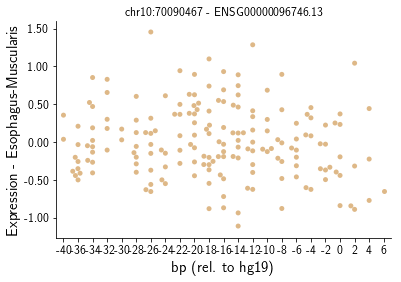

ENSG00000105607.8,chr19,13001378,Thyroid 0.00259979402242471


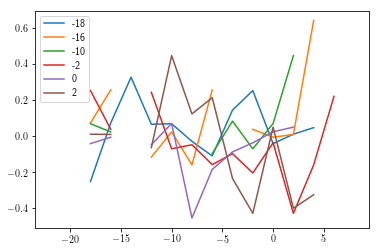

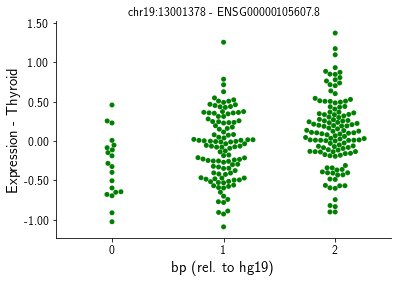

ENSG00000095752.2,chr19,55882283,Brain-Caudate(basalganglia) 0.847533753155789


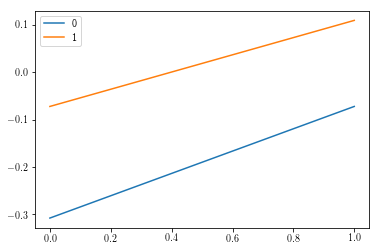

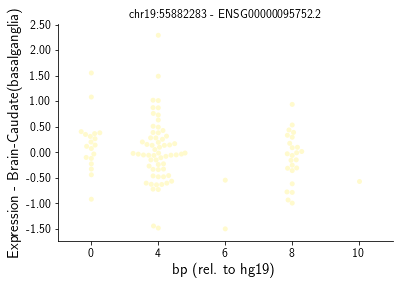

ENSG00000147869.4,chr9,14723163,Brain-Caudate(basalganglia) 0.5987303704036059


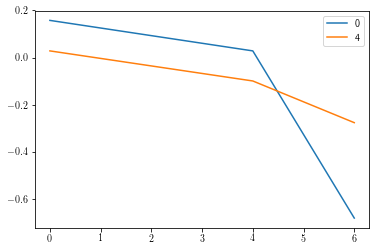

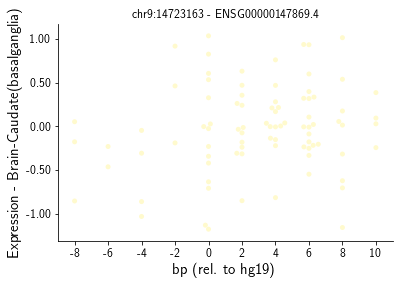

ENSG00000158560.10,chr7,95401424,Adipose-Visceral(Omentum) 0.023579090705808


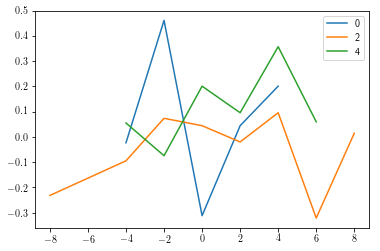

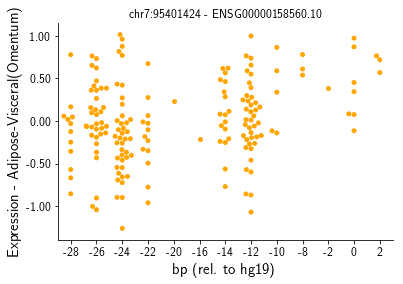

ENSG00000204219.5,chr1,23751670,Adipose-Visceral(Omentum) 0.29011862893677803


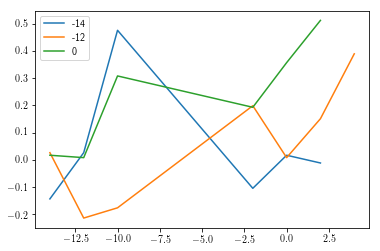

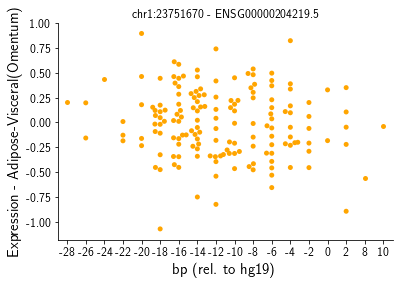

ENSG00000179562.2,chr7,127234099,Esophagus-Mucosa 0.11774072500826402


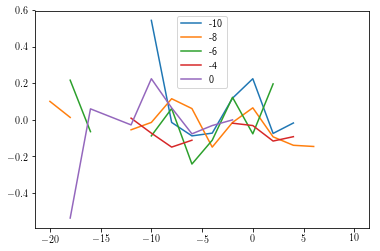

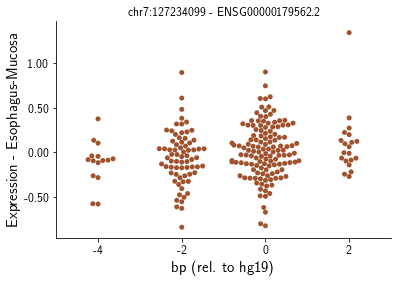

ENSG00000143067.4,chr1,120190812,Muscle-Skeletal 0.00295880185168774


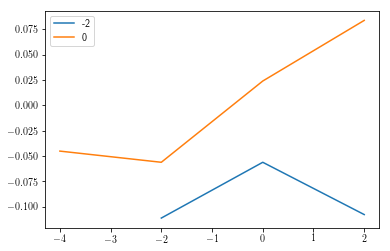

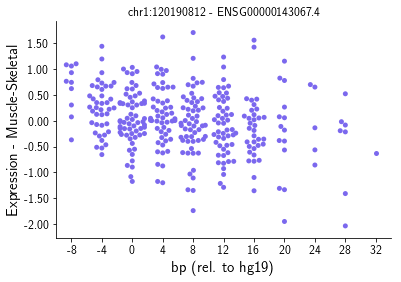

ENSG00000177599.8,chr19,11909008,Nerve-Tibial 0.0104242190341328


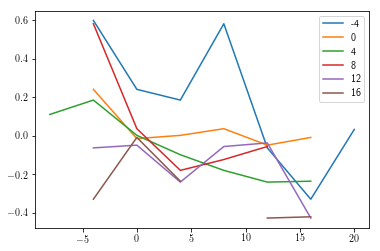

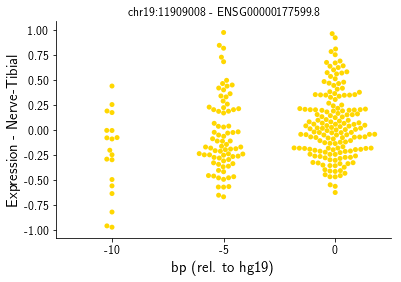

ENSG00000139278.5,chr12,75874066,Brain-Caudate(basalganglia) 0.322148802011984


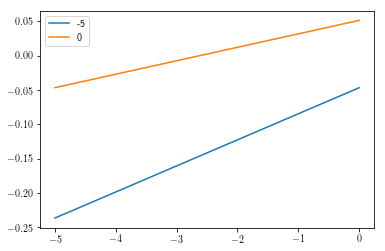

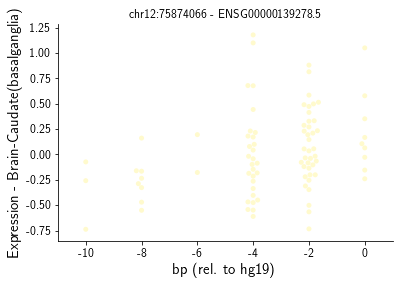

ENSG00000145423.4,chr4,154710658,Nerve-Tibial 0.18699841964803


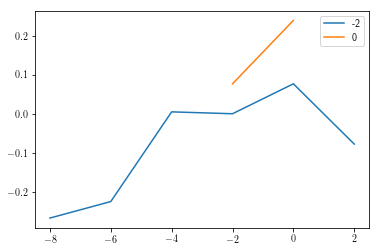

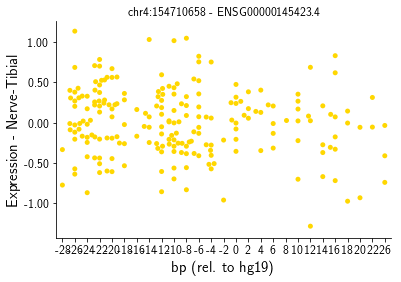

ENSG00000141384.7,chr18,23805528,Artery-Tibial 0.0362657678070657


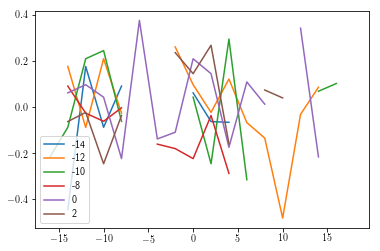

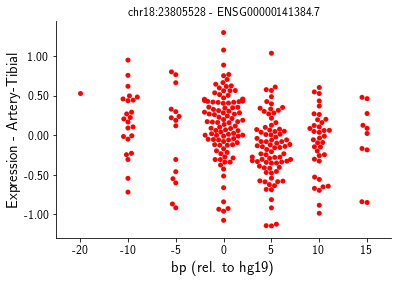

ENSG00000166292.7,chr17,53809854,Esophagus-Mucosa 0.262789196937537


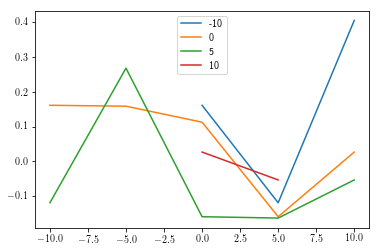

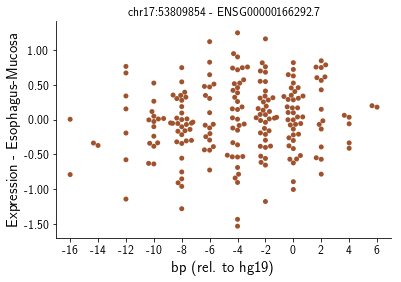

ENSG00000204711.4,chr9,72435349,Nerve-Tibial 0.0619028050581924


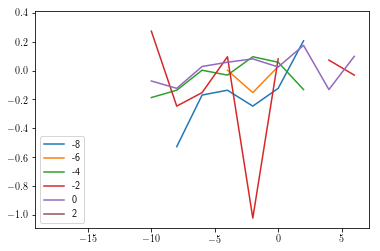

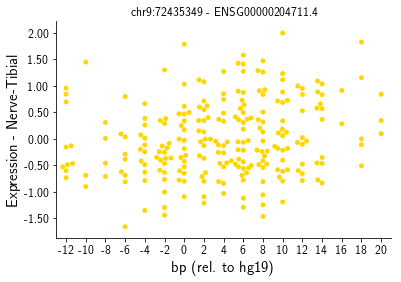

ENSG00000187824.4,chr17,10633990,WholeBlood 0.0041273878948438


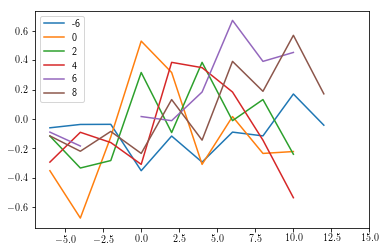

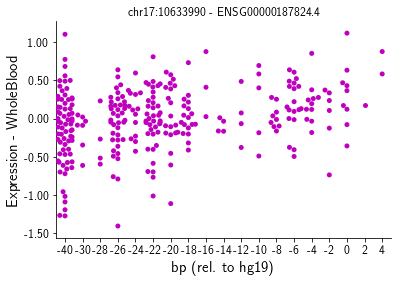

ENSG00000125398.5,chr17,70116825,Esophagus-Muscularis 0.54302559284917


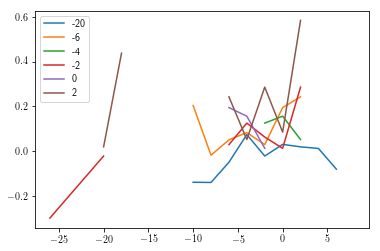

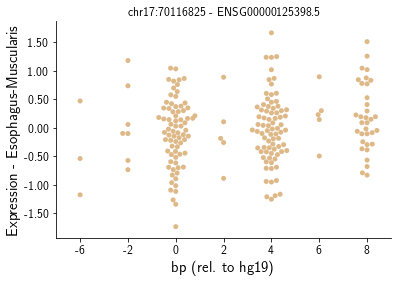

ENSG00000114771.9,chr3,151531499,Lung 0.00393283284975696


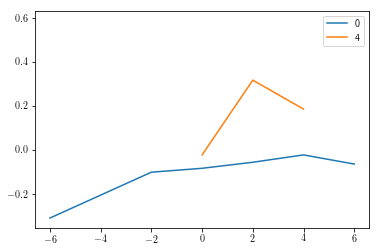

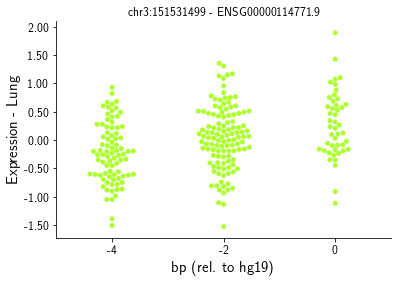

ENSG00000164180.9,chr5,87565578,Heart-LeftVentricle 0.20667670364266197


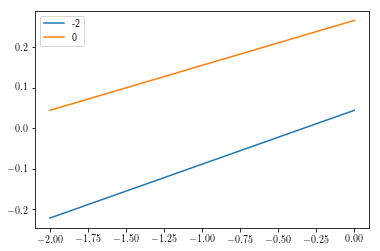

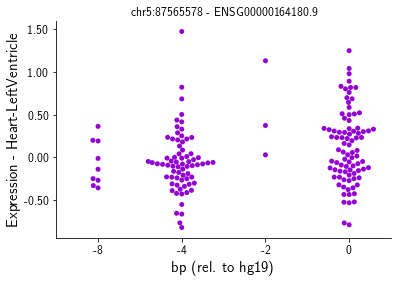

ENSG00000140030.4,chr14,88471185,WholeBlood 0.0356878456803961


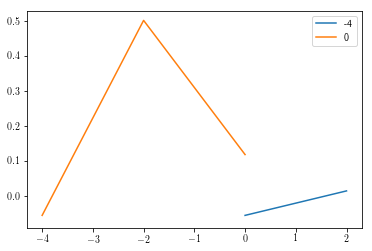

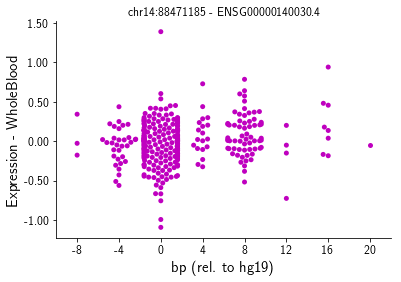

ENSG00000173064.6,chr12,112820132,WholeBlood 0.197717507774879


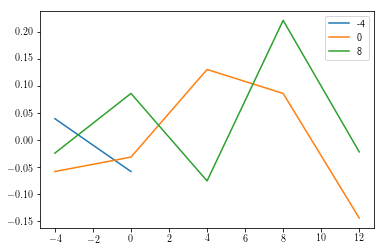

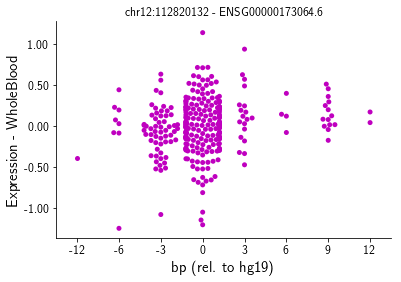

ENSG00000132359.9,chr17,2680118,Brain-Caudate(basalganglia) 0.43730957722007296


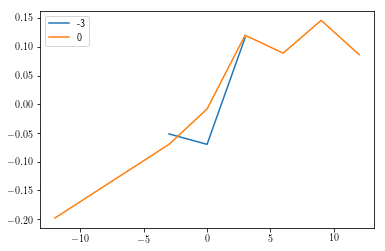

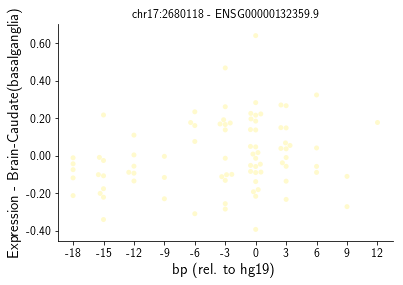

ENSG00000143384.8,chr1,150552235,Thyroid 0.3962300280231951


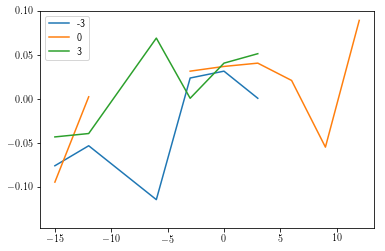

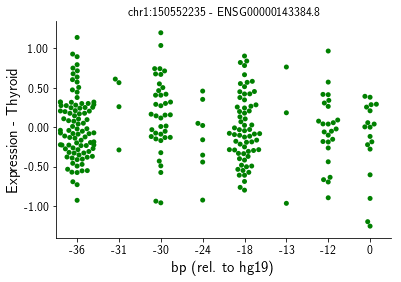

ENSG00000132623.11,chr20,10015524,Esophagus-Muscularis 0.0042183394924217394


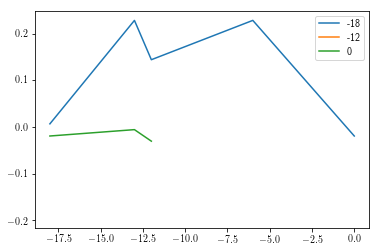

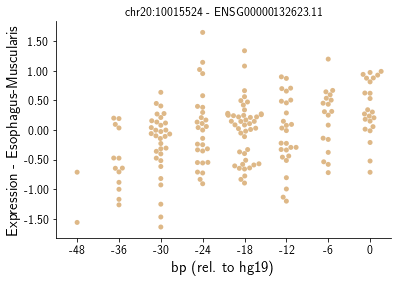

ENSG00000126217.16,chr13,113548560,Lung 0.506122383470825


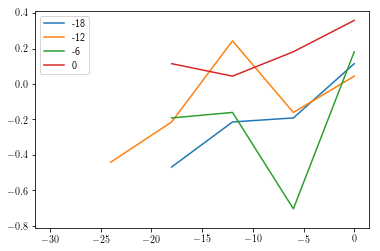

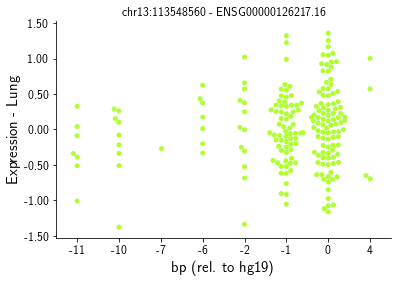

ENSG00000128710.5,chr2,176973388,Thyroid 0.0046879196016126785


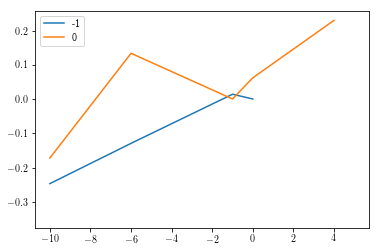

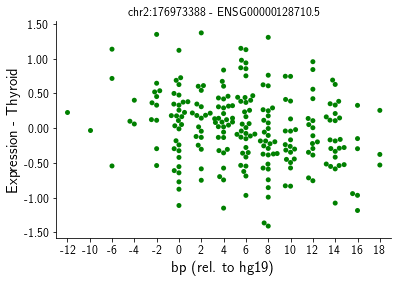

ENSG00000004777.14,chr19,36265315,Esophagus-Mucosa 0.00316632844242486


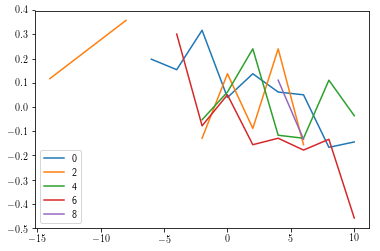

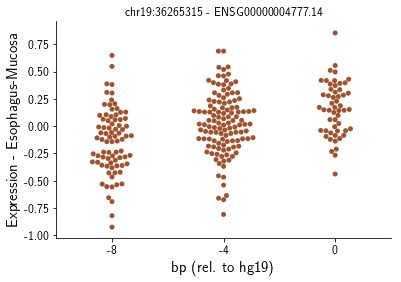

ENSG00000079841.14,chr6,72596302,Skin-SunExposed(Lowerleg) 0.3879348759080801


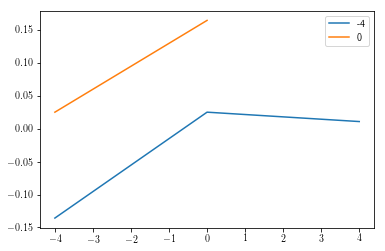

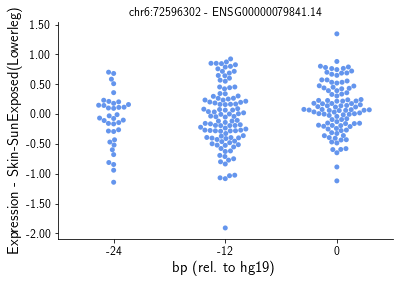

ENSG00000006606.4,chr7,75419316,Lung 0.319221947477017


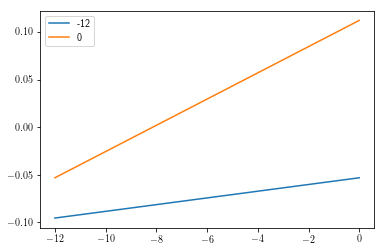

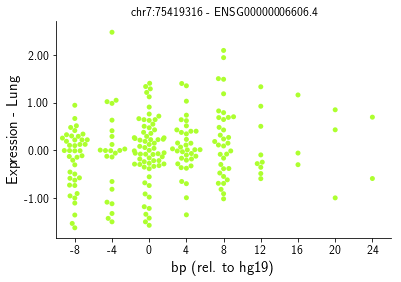

ENSG00000188735.8,chr12,122150572,Skin-NotSunExposed(Suprapubic) 0.4640668644043761


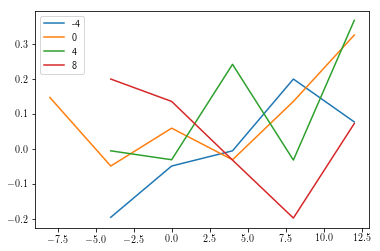

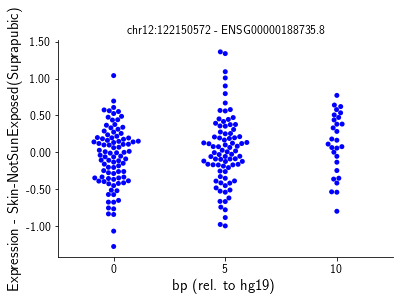

ENSG00000227184.3,chr8,144952717,Muscle-Skeletal 0.0994471781117662


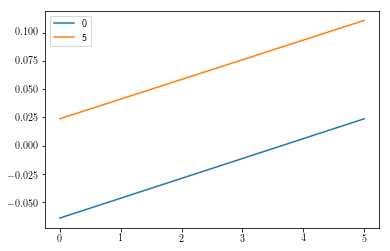

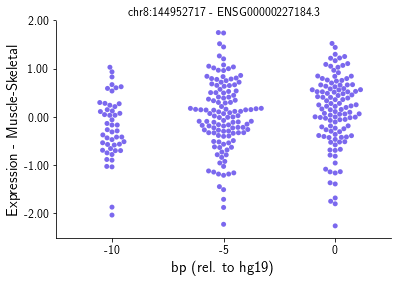

ENSG00000171621.9,chr1,9352856,Nerve-Tibial 0.269852033098507


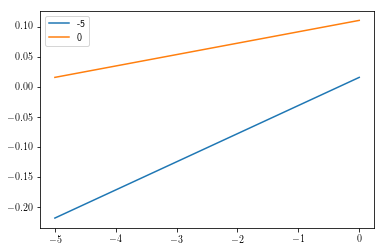

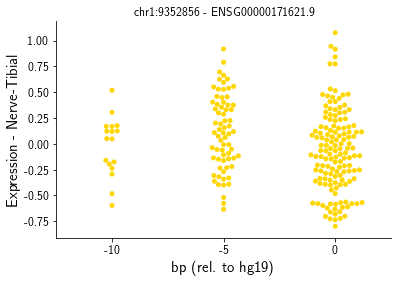

ENSG00000140807.4,chr16,50582162,Thyroid 0.382924153963737


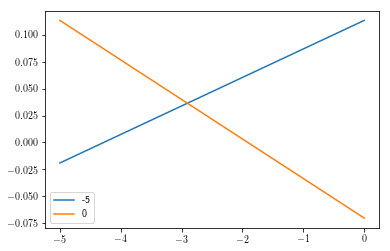

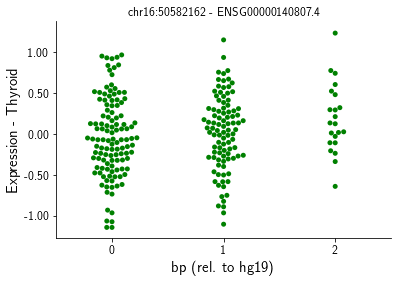

ENSG00000120915.9,chr8,27348217,WholeBlood 0.00420341531969437


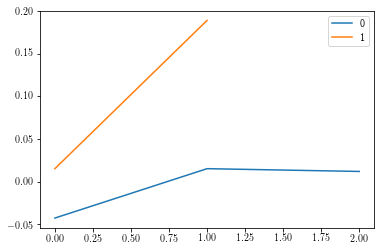

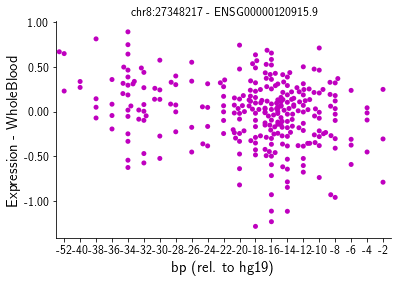

ENSG00000169884.9,chr12,49365622,Adipose-Subcutaneous 0.391748431752169


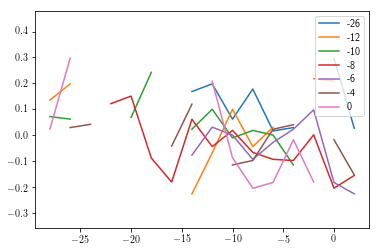

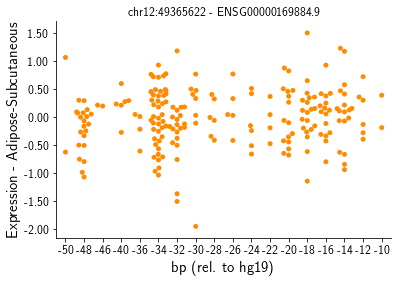

ENSG00000085998.9,chr1,46664191,Artery-Tibial 0.0943227033919633


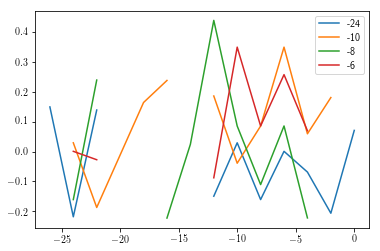

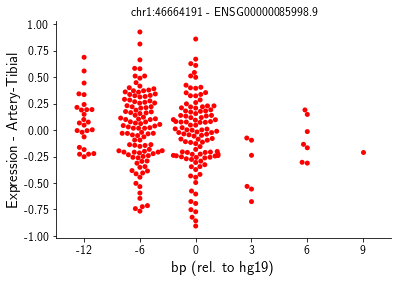

ENSG00000153898.8,chr1,85462853,Esophagus-Mucosa 0.00316632844242486


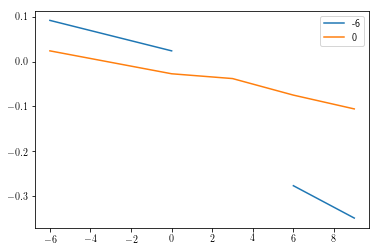

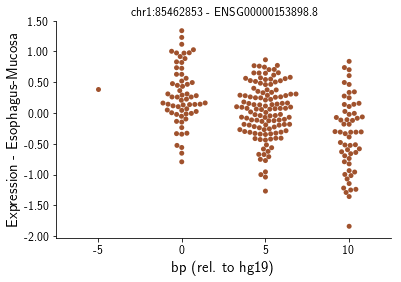

ENSG00000167107.8,chr17,48503463,Nerve-Tibial 0.0023530881007673


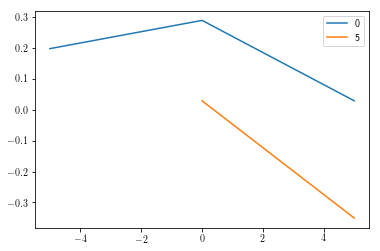

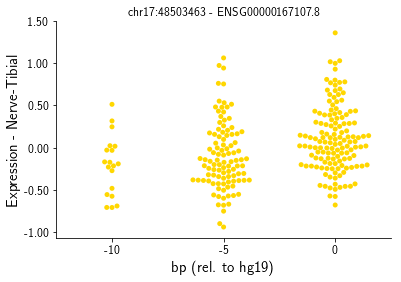

ENSG00000150873.7,chr2,11273124,Adipose-Subcutaneous 0.0642160490647812


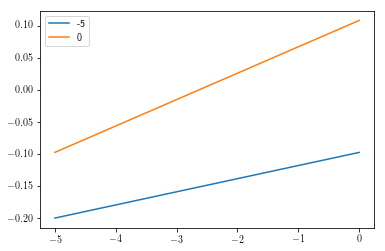

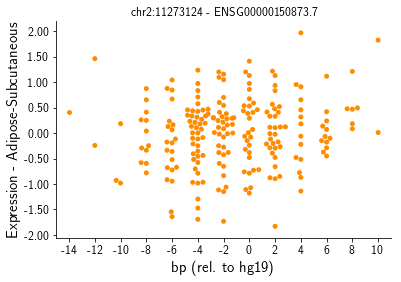

ENSG00000163686.9,chr3,58223190,Thyroid 0.00257003323371342


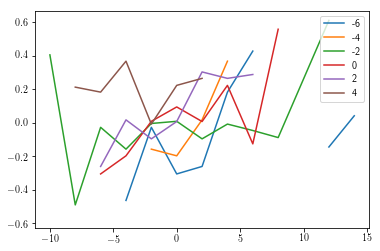

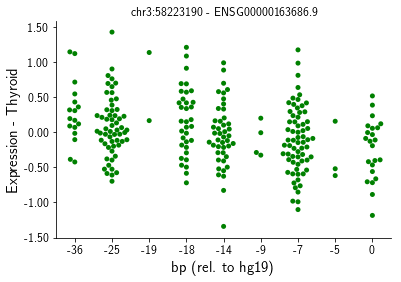

ENSG00000090905.13,chr16,24740990,WholeBlood 0.0041273878948438


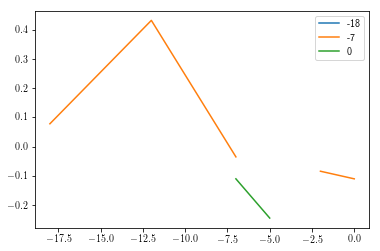

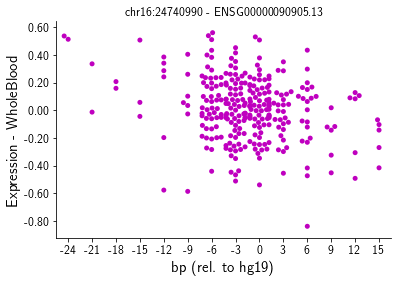

ENSG00000179399.9,chr13,92050905,Thyroid 0.15651729463859199


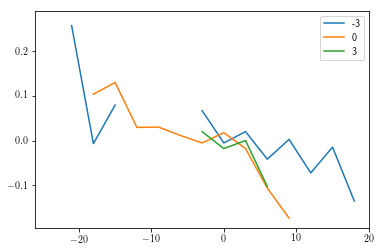

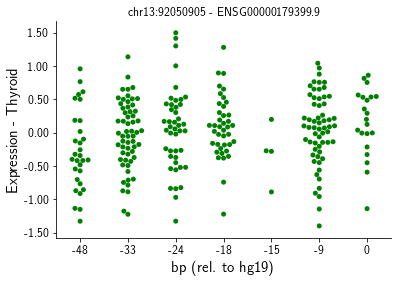

ENSG00000157601.9,chr21,42792209,Heart-LeftVentricle 0.328125106413727


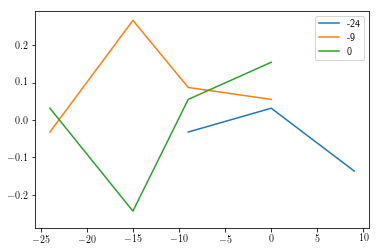

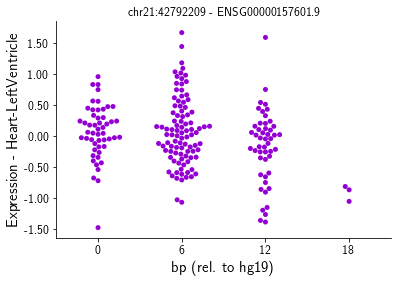

ENSG00000141096.4,chr16,68014740,Thyroid 0.2500132745868061


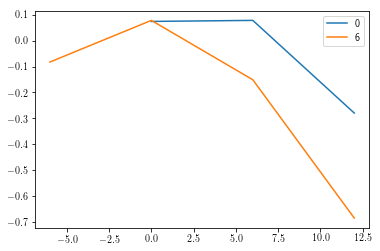

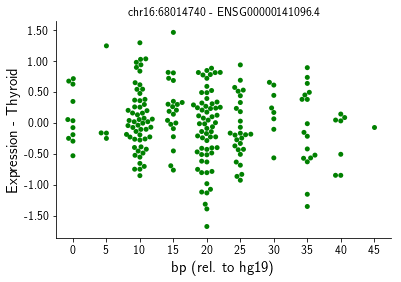

ENSG00000160213.5,chr21,45196326,Thyroid 0.00241108743886709


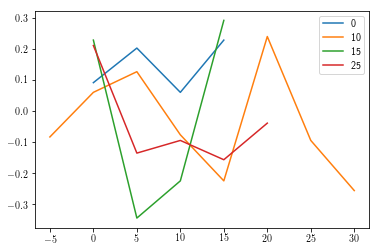

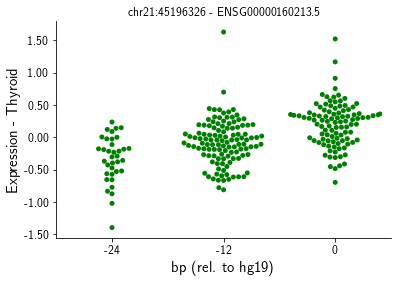

ENSG00000106733.16,chr9,77703133,Brain-Cerebellum 0.00969082408548777


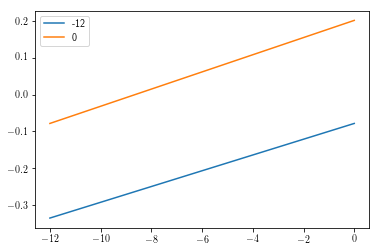

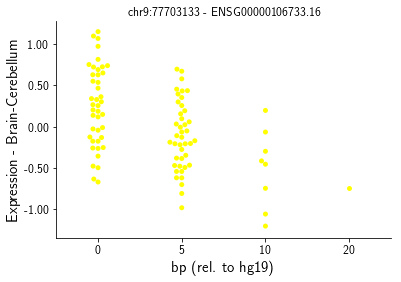

ENSG00000177697.13,chr11,832893,Muscle-Skeletal 0.00295880185168774


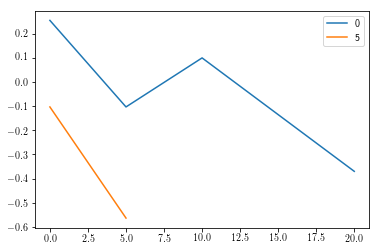

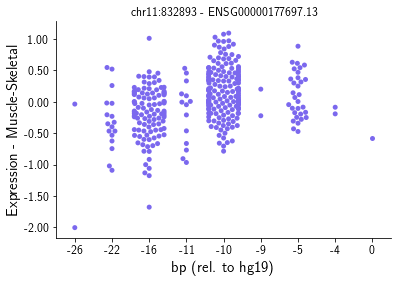

ENSG00000137764.15,chr15,67835068,Adipose-Subcutaneous 0.00273365933309969


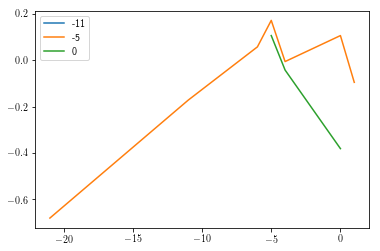

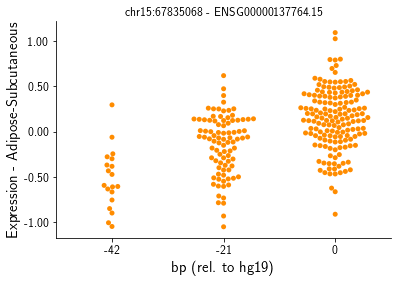

ENSG00000065060.12,chr6,34759904,Skin-NotSunExposed(Suprapubic) 0.005098949313448929


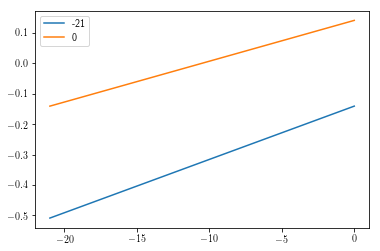

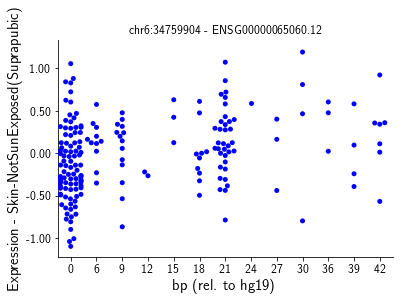

ENSG00000213221.4,chr9,139258185,Artery-Aorta 0.341627984122042


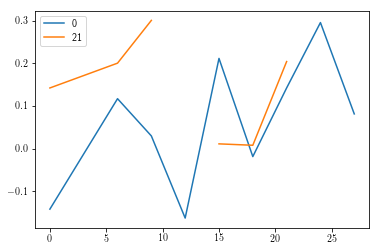

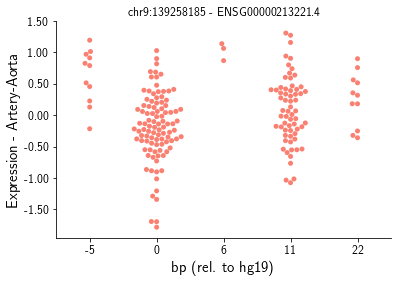

ENSG00000147650.7,chr8,105601193,Nerve-Tibial 0.00519731170484072


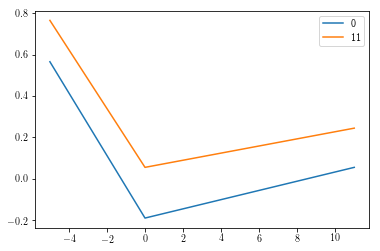

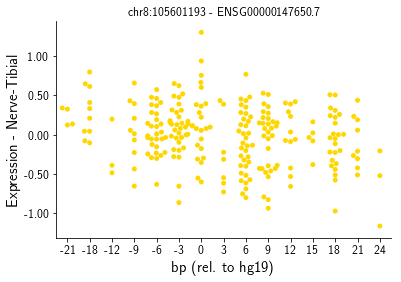

ENSG00000140443.9,chr15,99192260,Cells-Transformedfibroblasts 0.1296017930972


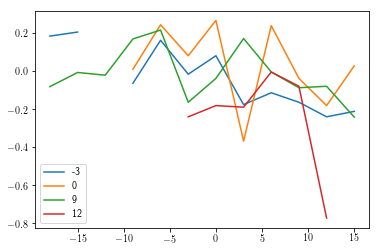

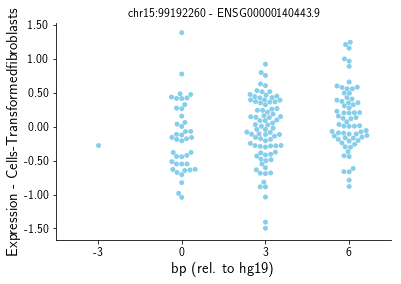

ENSG00000141580.11,chr17,80606365,Cells-Transformedfibroblasts 0.0034671569970244


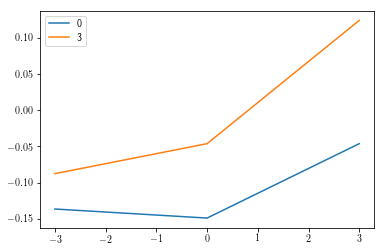

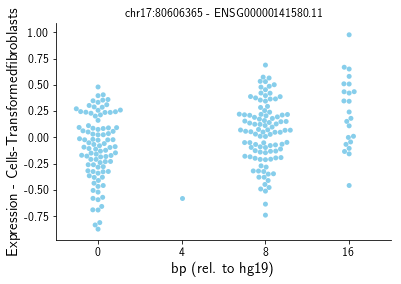

ENSG00000100325.10,chr22,30234193,WholeBlood 0.0059668164124990295


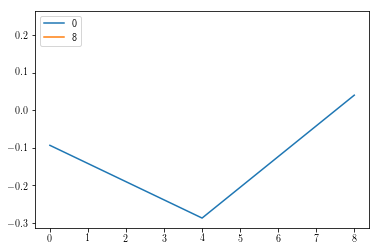

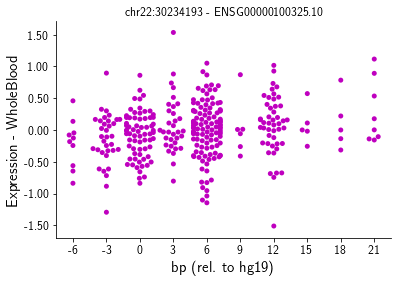

ENSG00000167100.10,chr17,48207168,Adipose-Subcutaneous 0.0101189403956107


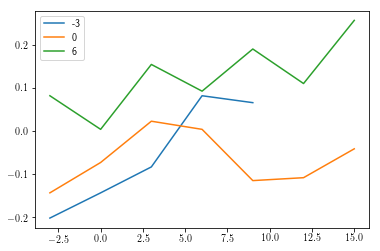

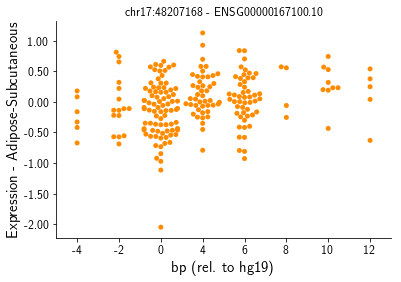

ENSG00000122547.6,chr7,36192840,Skin-NotSunExposed(Suprapubic) 0.005069126655112661


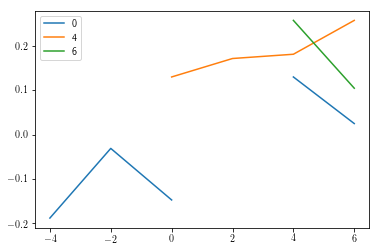

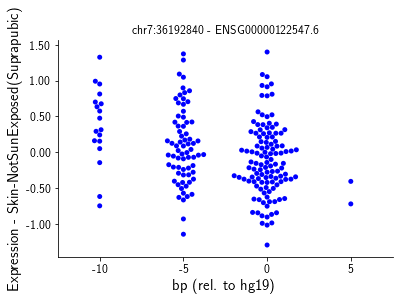

ENSG00000198742.5,chr7,98741639,Esophagus-Muscularis 0.5860051253353741


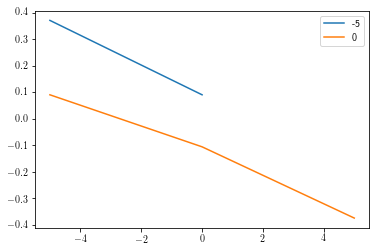

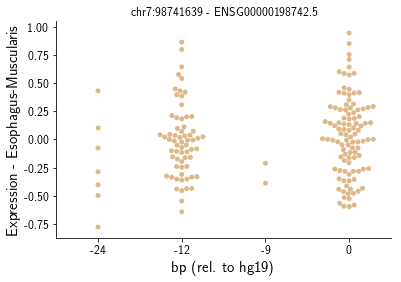

ENSG00000123159.11,chr19,14606854,Skin-NotSunExposed(Suprapubic) 0.0398417456152502


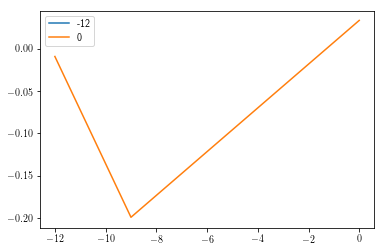

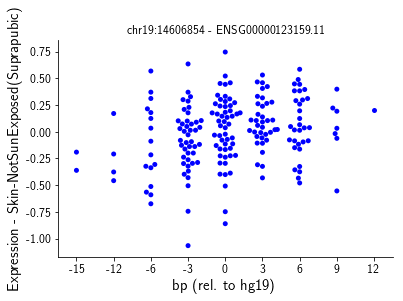

ENSG00000105509.6,chr19,52227138,Skin-NotSunExposed(Suprapubic) 0.153069767412833


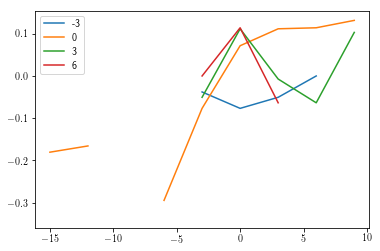

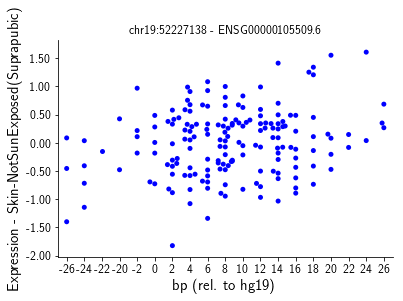

ENSG00000148180.12,chr9,123970202,Skin-SunExposed(Lowerleg) 0.285629482373249


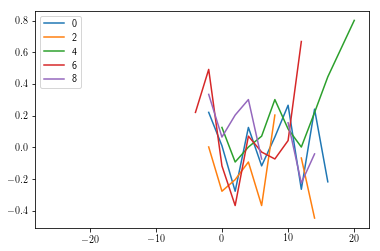

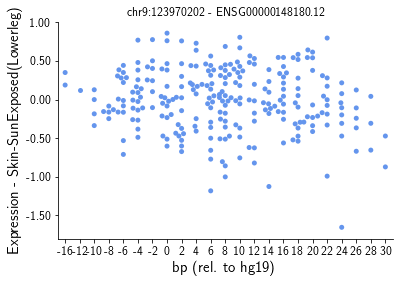

ENSG00000116127.13,chr2,73613032,Esophagus-Muscularis 0.0604520447186892


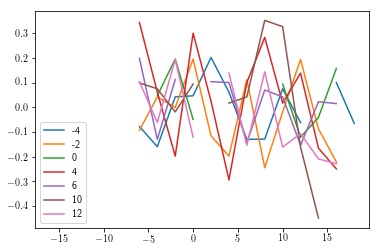

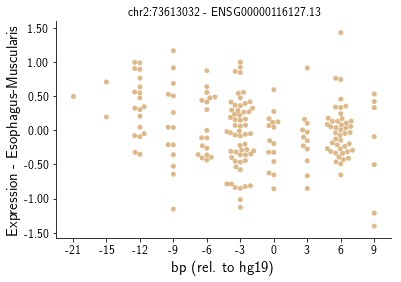

ENSG00000011114.10,chr14,93799285,Cells-Transformedfibroblasts 0.0038160212206509603


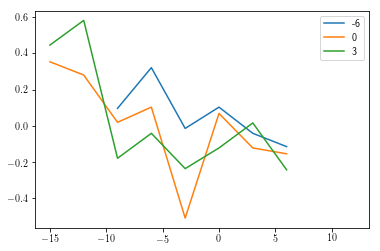

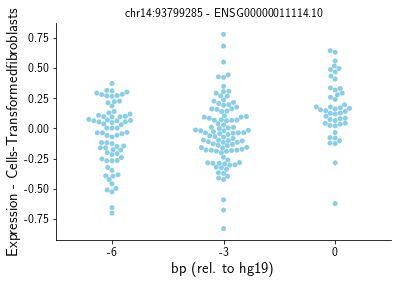

ENSG00000120254.11,chr6,151186858,Nerve-Tibial 0.0632586058826017


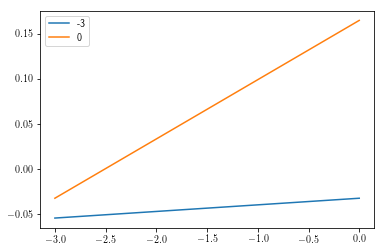

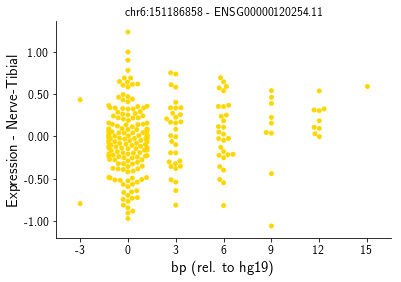

ENSG00000176463.9,chr15,92397101,WholeBlood 0.0342358454318049


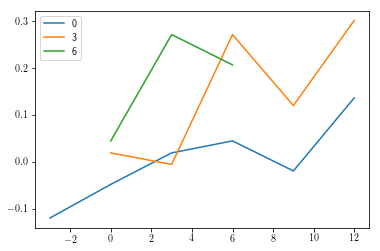

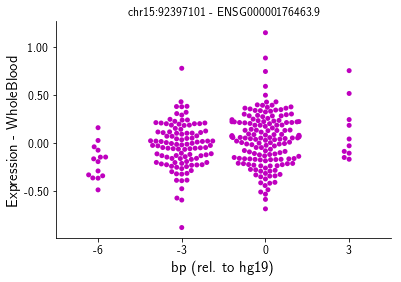

ENSG00000139514.8,chr13,30169644,Skin-SunExposed(Lowerleg) 0.322399791543234


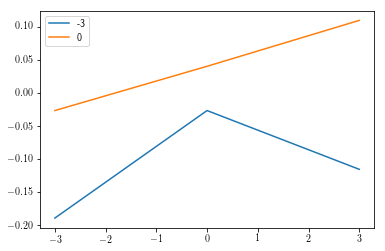

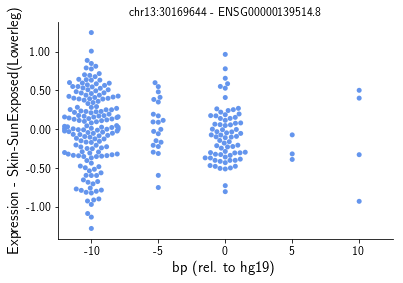

ENSG00000115825.5,chr2,37551759,Muscle-Skeletal 0.00917709587404809


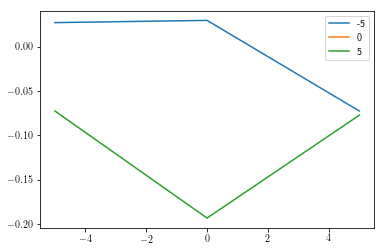

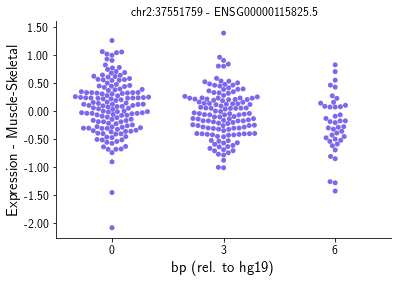

ENSG00000084674.9,chr2,21266752,Esophagus-Muscularis 0.301024575261196


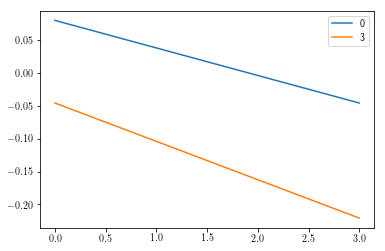

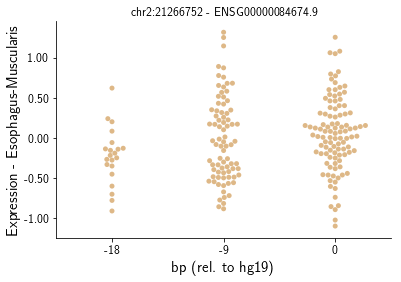

ENSG00000106780.7,chr9,123476538,Thyroid 0.11309328593293302


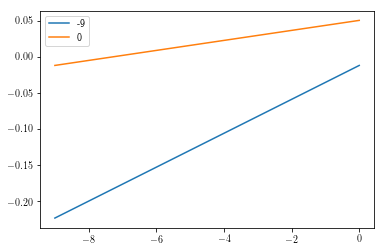

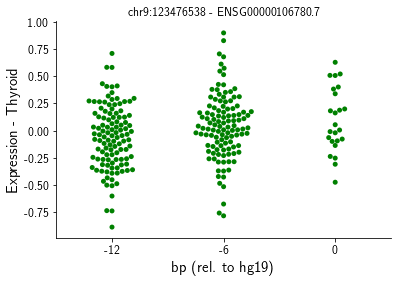

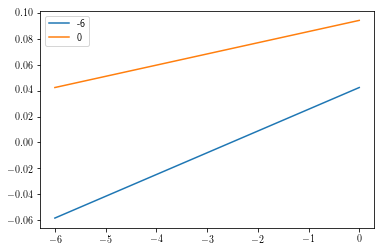

In [12]:
for i in range(len(GENES)):
    print("%s,%s,%s,%s %s"%(GENES[i], CHROMS[i], STARTS[i], TISSUES[i], QVALS[i]))
    ExtractData(GENES[i], CHROMS[i].replace("chr",""), STARTS[i], TISSUES[i])
    PlotESTR(GENES[i], TISSUES[i], CHROMS[i].replace("chr",""), STARTS[i], COLORS)
    PlotHeatmap()